In [59]:
import numpy as np
import matplotlib.pyplot as plt

In [60]:
class StochasticSIR:
    def __init__(self, initial_SIR, beta, gamma, tmax):
        self.current_SIR = initial_SIR
        self.SIR = self.initialize()
        self.beta = beta
        self.gamma = gamma
        self.t = [0]
        self.tmax = tmax

    def initialize(self):
        """
        Changes self.current_SIR to a dictionary, each value in the original list being assigned to the corresponding key in the new dictionary, being either 'S', 'I', ''R' or 'N'.
        Creates and returns dictionary with lists for S, I, R, and N. By default, N is the sum of the subpopulations.
        """ 
        S, I, R = self.current_SIR
        self.current_SIR = {'S': S, 'I': I, 'R': R, 'N': S + I + R}
        return {'S': [S], 'I': [I], 'R': [R], 'N': [S + I + R]}

    def infection_event(self):
        """
        Infection event: decreases susceptible population and increase infected population by 1
        """
        
        self.current_SIR['S'] -= 1
        self.current_SIR['I'] += 1

    def recovery_event(self):
        """
        Recovery event: decrease infected population and increased recovered population by 1
        """

        self.current_SIR['I'] -= 1
        self.current_SIR['R'] += 1

    def update_SIR(self):
        """
        Updates the dictionary containing the dynamics according to the most recent status of the simulation.
        """ 

        S, I, R, N = self.current_SIR.values()
        self.SIR['S'].append(S)
        self.SIR['I'].append(I)
        self.SIR['R'].append(R)
        self.SIR['N'].append(S + I + R)

    def run(self, N = 1):
        """
        Runs a simulation of the SIR model using the Gillespie algorithm until a specified
        maximum time (tmax) is reached or until the infected population (I) becomes zero, whichever
        occurs first.

        The Gillespie algorithm is used to model stochastic events, being the disease transmission and recovery.
        During each time step, the following steps are performed:
        1. Get the most recent values of susceptible (S), infected (I), recovered (R), and total population (N).
        2. Calculate the probabilities of two events:
        - Event 1: A single infection.
        - Event 2: A single recovery.
        3. Calculate the length of the current time step (dt) based on exponential distributions
        and the sum of event probabilities.
        4. Advance the simulation time (t) by adding dt to the previous time.
        5. Perform either an infection event or a recovery event based on generated probabilities.
        6. Update the dictionary containing all the disease dynamics.
        """
        results = []

        for run in range(N):

            # Until tmax is reached. Number of timesteps is unknown, so for-loop is not useful
            while self.t[-1] < self.tmax:

                # Get most recent values of S, I, R and N
                S, I, R, N = self.current_SIR.values()

                # Stop simulation if infected population reaches zero
                if I == 0:
                    dt = self.tmax - self.t[-1]
                    self.t.append(self.t[-1] + dt)

                else:

                    # Calculate probabilities of event 1 (single infection) and event 2 (single recovery)
                    probabilities = [self.beta * S * I / N, self.gamma * I]
                    probabilities_sum = sum(probabilities)

                    # Calculate length current timestep and add it to self.t
                    dt= np.random.exponential(scale = 1 / probabilities_sum)
                    self.t.append(self.t[-1] + dt)

                    # Do infection or recovery event according to probabilities
                    if np.random.uniform(0, 1) * probabilities_sum <= probabilities[0]:

                        # 1 susceptible becomes infected
                        self.infection_event()

                    # 1 infected becomes recovered
                    else:
                        self.recovery_event()

                # Update dictionary containing all dynamics
                self.update_SIR()

                results.append(self.SIR)

        if N > 1:
            return results



    def plot(self, ax, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered', label=False):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """
        if label:
            label_addition = " stochastic"
        else:
            label_addition = ""
            
        # If the susceptible curve is to be plotted
        if S:
            ax.plot(self.t, self.SIR['S'], label=f"{S_label}{label_addition}", color='blue')

        # If the infected curve is to be plotted
        if I:
            ax.plot(self.t, self.SIR['I'], label=f"{I_label}{label_addition}", color='green')

        # If the recovered curve is to be plotted
        if R:
            ax.plot(self.t, self.SIR['R'], label=f"{R_label}{label_addition}", color='purple')

        # If the population size curve is to be plotted
        if N:
            ax.plot(self.t, self.SIR['N'], label=f'Population size{label_addition}', color='orange')

In [61]:
class ContinuousSIR:
    def __init__(self, initial_SIR, tmax, dt, beta, gamma):
        self.beta = beta
        self.gamma = gamma
        self.tmax = tmax
        self.dt = dt
        self.population_size = sum(initial_SIR)
        self.n_points = int(tmax/dt)
        self.t = np.linspace(0, self.tmax, self.n_points)
        self.sir = self.initiate(initial_SIR)

    def initiate(self, initial_SIR):
        """
        Initiales the array where the results will be stored. Fills in start conditions.
        """ 

        SIR = np.zeros([len(self.t), 4])
        S, I, R = initial_SIR
        N = S + I + R
        SIR[0] = np.array([[S/N, I/N, R/N, N]])
        return SIR

    def get_derivatives(self, y):
        """
        Calculates the time derivative of S, I, and R in the SIR model according to the current values of S I and R, and the values of beta, gamma, mu, nu and rho.
        """

        # Unpack parameters from array
        S, I, R, N = y
        
        dS = - self.beta * S * I
        dI = self.beta * S * I - self.gamma * I
        dR = self.gamma * I
        dN = dS + dI + dR

        # Return array with values for the time derivatives of S, I, and R. Sets value for N to 0, this will be calculated and adjusted in run()
        return np.array([dS, dI, dR, dN])

    def run(self):
        """
        Numerically approximates the set of differential equations of the SIR model according to the 4th order Runge-Kutta method.
        """

        # For each timestep
        for i in range(len(self.t) - 1):

            # Do timestep according to Runge-Kutta 4th order
            y = self.sir[i]
            k_1 = self.dt * self.get_derivatives(y)
            k_2 = self.dt * self.get_derivatives(y + k_1 / 2.)
            k_3 = self.dt * self.get_derivatives(y + k_2 / 2.)
            k_4 = self.dt * self.get_derivatives(y + k_3)

            # Update values for S, I, R and N
            self.sir[i+1] = y + 1/6 * (k_1 + 2 * k_2 + 2 * k_3 + k_4)
            
        return self.sir

    def plot(self, ax, S = True, I = True , R = True, N = True, S_label = 'Susceptible', I_label = 'Infected', R_label = 'Recovered'):
        """
        Plots the dynamics of the model as a function of time. By default, S, I, R and N are shown, but can be removed if needed.
        Takes an ax as input so the figure can be edited outside of this function. Also takes optional figure labels.
        """

        if S:
            ax.plot(self.t, self.population_size * self.sir[:,0], '--', label=f"{S_label} continuous", color='blue')
        if I:
            ax.plot(self.t, self.population_size * self.sir[:,1], '--', label=f"{I_label} continuous", color='green')
        if R:
            ax.plot(self.t, self.population_size * self.sir[:,2], '--', label=f"{R_label} continuous", color='purple')
        if N:
            ax.plot(self.t, self.sir[:,3], '--', label='Population size continuous', color='orange')


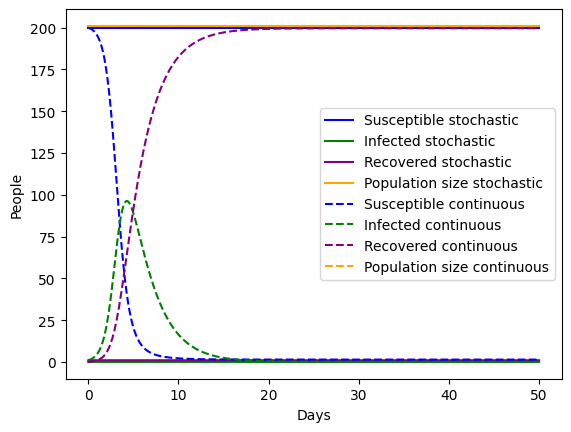

In [62]:
# Initial values SIR model
initial_SIR = [200, 1, 0]
beta = 2
gamma = 0.4
tmax = 50

# Run stochastic SIR simulation
infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
infection.run()

# Make ax and generate plot
fig, ax = plt.subplots(1)
infection.plot(ax, label=True)

# Set tmax to highest t in stochastic model
tmax = infection.t[-1]
dt = 0.1

# Run continuous SIR simulation
continuous_infection = ContinuousSIR(initial_SIR, tmax, dt, beta, gamma)
continuous_infection.run()
continuous_infection.plot(ax)

# Compare outcomes of different approaches
plt.legend()
plt.xlabel('Days')
plt.ylabel('People')
plt.show()

In [63]:
print(infection.SIR['I'])
print(infection.t)

[1, 0, 0]
[0, 0.12644435920163782, 50.0]


In [82]:
def get_average(N, initial_SIR, beta, gamma, tmax, dt=0.1):
    averaged_results = {}
    t = []
    for run in range(N):
        infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
        infection.run()
        stocastic_SIR = infection.SIR
        stochastic_t = infection.t
        SIR = {'S': [stocastic_SIR['S'][0]],
               'I': [stocastic_SIR['I'][0]],
               'R': [stocastic_SIR['R'][0]]
                     }

        t_index = 1
        current_t = stochastic_t[t_index]

        for i in range((ts:= int(tmax / dt))-1):
            t.append(i)

            if i < current_t:
                print(i)
                SIR['S'].append(SIR['S'][-1])
                SIR['I'].append(SIR['I'][-1])
                SIR['R'].append(SIR['R'][-1])

            elif t_index < len(stochastic_t) - 1:
                t_index += 1
                current_t = stochastic_t[t_index]
                print(current_t)
                SIR['S'].append(stocastic_SIR['S'][t_index])
                SIR['I'].append(stocastic_SIR['I'][t_index])
                SIR['R'].append(stocastic_SIR['R'][t_index])

        print(len(SIR['S']), ts, current_t)
        averaged_results['S'] = [SIR['S'][j] / N for j in range(ts - 1)]
        averaged_results['I'] = [SIR['I'][j] / N for j in range(ts - 1)]
        averaged_results['R'] = [SIR['R'][j] / N for j in range(ts - 1)]

    return averaged_results, t



SIR, t = get_average(1, initial_SIR, beta, gamma, tmax)
infection = StochasticSIR(initial_SIR, beta, gamma, tmax)
infection.SIR = SIR
infection.t = t

fig, ax = plt.subplots(1)
infection.plot(ax, N=False)


0
0.4648660281990202
0.49140917890075353
50.0
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
51 500 50.0


IndexError: list index out of range